In [143]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import mglearn
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family']='Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False

from warnings import filterwarnings
filterwarnings("ignore")
from konlpy.tag import Okt
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud 
import platform
from wordcloud import WordCloud, STOPWORDS

# 1. 직접 라벨링한 데이터의 텍스트 분석
- wordcloud

In [144]:
df = pd.read_csv('data/0412/재보궐선거댓글데이터_최종_by_model2.csv', index_col=0)
df

,area,candidate,candidate_eval,party,party_eval,title_comment,area_candidate
0,NaN,NaN,NaN,NaN,NaN,재보궐 부산 김영춘 박형준 서울도 양자 대결 철수야 뜸 들이지 말고 애국하는 마...,박영선
1,1.0,1.0,0.0,NaN,NaN,재보궐 부산 김영춘 박형준 서울도 양자 대결 박영선은 정동영이 얻은 프로선에 머...,박영선
2,1.0,1.0,0.0,NaN,NaN,재보궐 부산 김영춘 박형준 서울도 양자 대결 빵선이가서울시장되면서울은공산국가수도...,박영선
3,1.0,1.0,0.0,1.0,0.0,재보궐 부산 김영춘 박형준 서울도 양자 대결 서울시장후보더듬당박빵선이는절대로서울...,박영선
4,2.0,NaN,NaN,1.0,0.0,재보궐 부산 김영춘 박형준 서울도 양자 대결 부산은오거돈선거이고 오거돈치부선거아...,박영선
...,...,...,...,...,...,...,...
144134,NaN,NaN,NaN,NaN,NaN,논설위원의 단도직입한일해저터널 경제성 없지만동북아 경제권 차원서 장기 검토해야 국민...,기타
144135,NaN,NaN,NaN,NaN,NaN,논설위원의 단도직입한일해저터널 경제성 없지만동북아 경제권 차원서 장기 검토해야 굳이...,박영선
144136,NaN,NaN,NaN,NaN,NaN,논설위원의 단도직입한일해저터널 경제성 없지만동북아 경제권 차원서 장기 검토해야 도랏...,기타
144137,NaN,NaN,NaN,NaN,NaN,논설위원의 단도직입한일해저터널 경제성 없지만동북아 경제권 차원서 장기 검토해야 이걸...,박영선


In [145]:
# 한글 정규표현식
def text_cleaning(text) :
    hangul = re.compile('[^ ㄱ-ㅣ가-힣]+')
    result = hangul.sub('', text)
    return result

In [146]:
df['title_comment'] = df['title_comment'].apply( lambda x: text_cleaning(x) )

### 후보별 데이터 분리하기

In [147]:
# 각 후보별 데이터 분리
ys = df.query( 'area == 1.0 & candidate == 1.0')['title_comment']
sh = df.query( 'area == 1.0 & candidate == 2.0')['title_comment']
yc = df.query( 'area == 2.0 & candidate == 1.0')['title_comment']
hj = df.query( 'area == 2.0 & candidate == 2.0')['title_comment']

In [148]:
# 각 후보별 데이터 개수 확인
ys.shape, sh.shape, yc.shape, hj.shape

((1303,), (1178,), (29,), (211,))

In [149]:
# 형용사만 분리하는 함수 생성
from konlpy.tag import Kkma

def get_pos(x) :
    tagger = Okt() # Okt로 형태소 분리하기
    pos = tagger.pos(x) 
    adj_list = []
    for i in pos:
        if i[1] == 'Adjective':
            # print(i[0], i[1])
            adj_list.append(i[0])
    return adj_list

In [150]:
# 각 후보별 '형용사'만 분리
ys_adjective = ys.apply(lambda x: get_pos(x))
sh_adjective = sh.apply(lambda x: get_pos(x))
yc_adjective = yc.apply(lambda x: get_pos(x))
hj_adjective = hj.apply(lambda x: get_pos(x))

In [151]:
# 각 후보별 '명사'만 분리
tagger = Okt()
ys_noun = tagger.nouns( ' '.join(ys.to_list()) )
sh_noun = tagger.nouns( ' '.join(sh.to_list()) )
yc_noun = tagger.nouns( ' '.join(yc.to_list()) )
hj_noun = tagger.nouns( ' '.join(hj.to_list()) )

## 3. 불용어 사전 정의 및 불용어 처리
- 출처: https://www.ranks.nl/stopwords/korean

In [220]:
# 불용어 사전
stopwords = pd.read_excel('data/한국어 불용어 사전.xlsx', header=None, names=['stopword'])
stopwords = stopwords['stopword'].to_list()

# 이다/아니다 제거
stopwords.extend(['이다','아니다','아닌가','아닌','아닐것','일것','아니라','아니겠나','입니다','아닙니다'])

# 지칭 형용사 제거
stopwords.extend(['이런','그런','저런','이것','저것','그것'])
# ※ 존재유무 형용사(있다/없다)는 for문으로 제거

In [221]:
stopwords.extend(['국민의 힘','더불어 민주당','더불어',
                  '민주당','국민','힘','사람','나라','말','놈','더',
                  '오세훈','박영선','김영춘','박형준','세훈','영선','영춘','형준',
                  '문재인','대통령','서울시장','주영진 뉴스','주영진','뉴스','후보'])

In [222]:
stopwords.append('야한다')
stopwords.append('같은')

In [223]:
# 불용어 사전 확인
# print(stopwords)

In [224]:
# 박영선 불용어 처리
ys_adj_list = []
for word_list in ys_adjective.values:
    for word in word_list:
        # print(word)
        # 불용어 사전에 존재하지 않고 & '있다','없다'가 아닌 형용사만 추출
        if word not in stopwords and word[0] not in ['있','없']:
            ys_adj_list.append(word)
            
# ys_adj_list

In [225]:
# 오세훈 불용어 처리
sh_adj_list = []
for word_list in sh_adjective.values:
    for word in word_list:
        # print(word)
        # 불용어 사전에 존재하지 않고 & '있다','없다'가 아닌 형용사만 추출
        if word not in stopwords and word[0] not in ['있','없']:
            sh_adj_list.append(word)
            
# sh_adj_list

In [226]:
# 김영춘 불용어 처리
yc_adj_list = []
for word_list in yc_adjective.values:
    for word in word_list:
        # print(word)
        # 불용어 사전에 존재하지 않고 & '있다','없다'가 아닌 형용사만 추출
        if word not in stopwords and word[0] not in ['있','없']:
            yc_adj_list.append(word)
            
# yc_adj_list

In [227]:
# 박형준 불용어 처리
hj_adj_list = []
for word_list in hj_adjective.values:
    for word in word_list:
        # print(word)
        # 불용어 사전에 존재하지 않고 & '있다','없다'가 아닌 형용사만 추출
        if word not in stopwords and word[0] not in ['있','없']:
            hj_adj_list.append(word)
            
# hj_adj_list

## 모델1에서 추출한 긍정/부정 형용사 사용

In [228]:
# 모델1(감성분석 모델)에서 단어별 긍정/부정 정도를 파악한 리스트 출력
import pickle
with open('data/0412/adj_list_by_model1_without_candidates.pickle', 'rb') as f:
    adj_list_by_model1 = pickle.load(f)

In [229]:
# 긍정 형용사 100개
positive_adj_list = adj_list_by_model1[:100]
positive_adj_list

[(19.424446612807408, '슬픈'),
 (12.616512254991168, '그래가지고'),
 (9.864917134231423, '안좋았다'),
 (8.832403325058944, '확실하다는'),
 (8.404917902994729, '사나운'),
 (8.075525556765733, '철저한'),
 (7.771068058056077, '작질'),
 (7.18550723738432, '칠하며'),
 (7.113232563743802, '순수한'),
 (6.8039674391995755, '인한'),
 (6.391267261835344, '없네요'),
 (6.345479779153223, '아름다운단'),
 (6.052466211847404, '역겨워'),
 (6.035499154241837, '사악하다'),
 (5.851436569510245, '대단하다'),
 (5.798431091752963, '야하는'),
 (5.734625521310528, '있는데이건'),
 (5.6049976962518615, '있겠나'),
 (5.318903502180852, '특이한'),
 (5.259213569404111, '높은지'),
 (5.203980395452749, '같다'),
 (5.193853660749509, '끔찍하다'),
 (5.147486720336838, '유리하다'),
 (5.14457038987285, '망해가네'),
 (5.0646577760854905, '미안하다'),
 (5.055724033661123, '특별히'),
 (5.021044731828071, '아프게'),
 (4.97672693153483, '있어서'),
 (4.930227918550125, '치사하고'),
 (4.923185544425619, '어렵던'),
 (4.8902688164279695, '심해야'),
 (4.809297084727651, '많냐'),
 (4.798177990550787, '안쓰러워'),
 (4.70552916141358, '가능한'),


In [230]:
# 부정 형용사 100개
negative_adj_list = adj_list_by_model1[-100:]
negative_adj_list

[(-2.4137694849959983, '비열한'),
 (-2.421262780587734, '억울함에'),
 (-2.428706627026528, '유리한'),
 (-2.438236202953058, '낭비하려고'),
 (-2.4760640434431687, '있네'),
 (-2.4803979086474652, '얌전한'),
 (-2.511687453082532, '지저분해'),
 (-2.5175136844877954, '급하고'),
 (-2.517740570824826, '정직한가'),
 (-2.531901103712986, '있으니'),
 (-2.586637683161139, '젊고'),
 (-2.588174646193157, '좁은'),
 (-2.6077016223045297, '없었'),
 (-2.6082983720142665, '미는'),
 (-2.6092360114612143, '느렸다'),
 (-2.6270886533431184, '있을것이다'),
 (-2.632320570282817, '안되겠네'),
 (-2.7086343606163443, '너무하는'),
 (-2.7240657703299513, '야하는지'),
 (-2.7305621144862924, '있냐'),
 (-2.730915332776358, '있는'),
 (-2.731948854892239, '먼가를'),
 (-2.800298731262462, '인해서'),
 (-2.8029995674659127, '있는지조차'),
 (-2.8133968075731928, '멋지다'),
 (-2.836310092249022, '옳고'),
 (-2.836364122892102, '많지'),
 (-2.9006749967553773, '장할'),
 (-2.916753888363678, '불쌍하네'),
 (-2.9203942488659838, '무섭네'),
 (-2.927352731118758, '안남았으니까'),
 (-2.946540194035538, '저급하다고'),
 (-3.013022914495

## 3. Wordcloud

In [231]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud 
import platform

In [232]:
print(platform.system())
if platform.system() == 'Windows':  
    font_path = "c:/Windows/Fonts/malgun.ttf"
else:
    pass

Windows


## 1. 박영선 후보

(-0.5, 799.5, 399.5, -0.5)

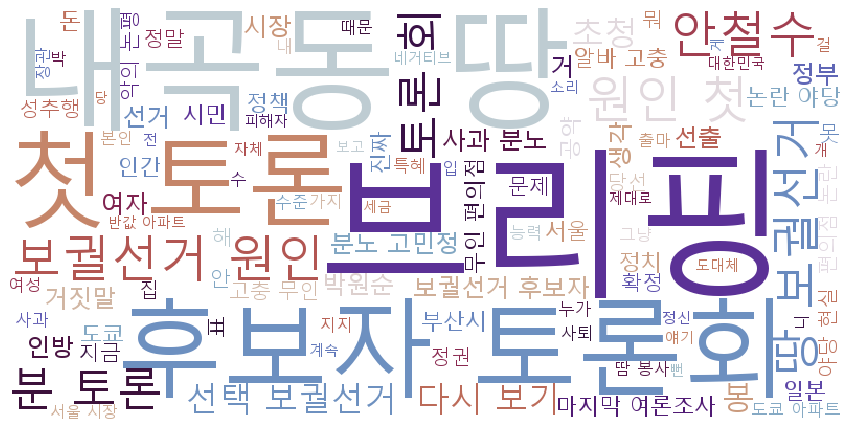

In [233]:
from wordcloud import WordCloud, STOPWORDS

wordcloud = WordCloud(font_path = font_path,
                     stopwords=stopwords,
                     colormap = 'twilight',
                     background_color='white',
                     max_words=100,
                     relative_scaling=0.1,   
                     width=800,
                     height=400
                     ).generate(' '.join(ys_noun))

plt.figure(figsize=(15,10))  
plt.imshow(wordcloud)       
plt.axis('off')

(-0.5, 799.5, 399.5, -0.5)

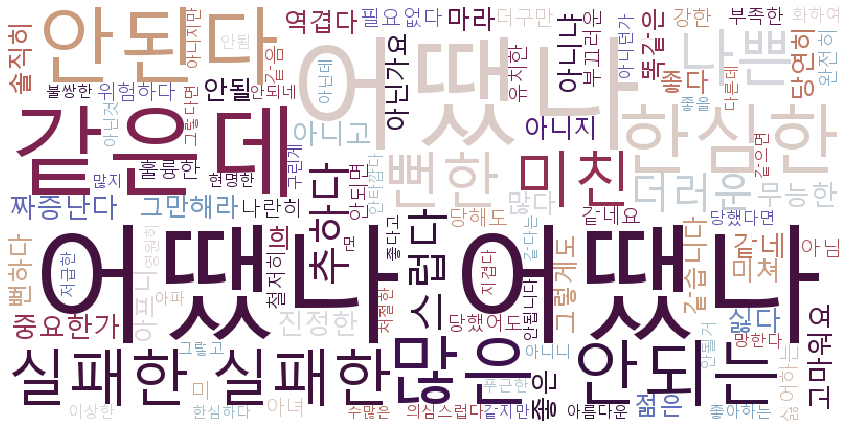

In [234]:
from wordcloud import WordCloud, STOPWORDS

wordcloud = WordCloud(font_path = font_path,
                     stopwords=stopwords,
                     colormap = 'twilight',
                     background_color='white',
                     max_words=100,
                     relative_scaling=0.1,   
                     width=800,
                     height=400
                     ).generate(' '.join(ys_adj_list))

plt.figure(figsize=(15,10))  
plt.imshow(wordcloud)       
plt.axis('off')

In [235]:
# 박영선 후보의 긍정/부정 형용사 비율 확인

no = 0
yes = 0
for i in ys_adj_list:
    if i in np.array(positive_adj_list)[:,1]:  
        yes += 1
    elif i in np.array(negative_adj_list)[:,1]:
        no += 1
    else:
        pass
print(f'전체 형용사 텍스트에서 긍정 비율: {yes / (no+yes)}')
ys_positive_ratio = yes / (no+yes)

전체 형용사 텍스트에서 긍정 비율: 0.5625


## 2. 오세훈 후보

(-0.5, 799.5, 399.5, -0.5)

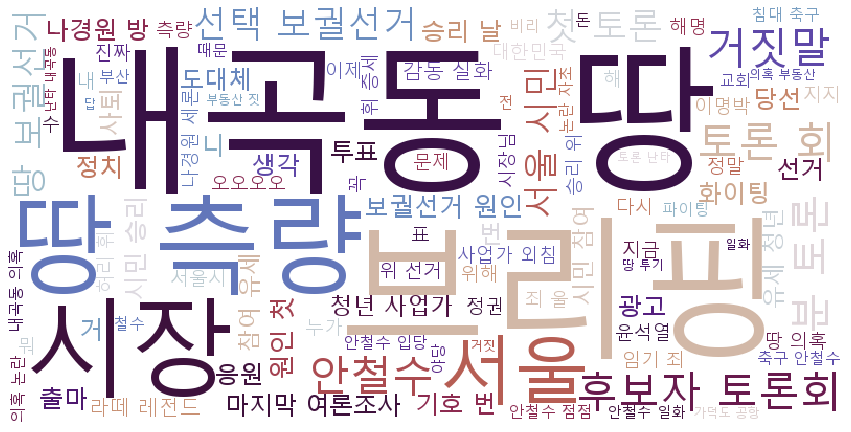

In [236]:
from wordcloud import WordCloud, STOPWORDS
stopwords
wordcloud = WordCloud(font_path = font_path,
                     stopwords=stopwords,
                     colormap = 'twilight',
                     background_color='white',
                     max_words=100,
                     relative_scaling=0.1,   
                     width=800,
                     height=400
                     ).generate(' '.join(sh_noun))

plt.figure(figsize=(15,10))  
plt.imshow(wordcloud)       
plt.axis('off')

(-0.5, 799.5, 399.5, -0.5)

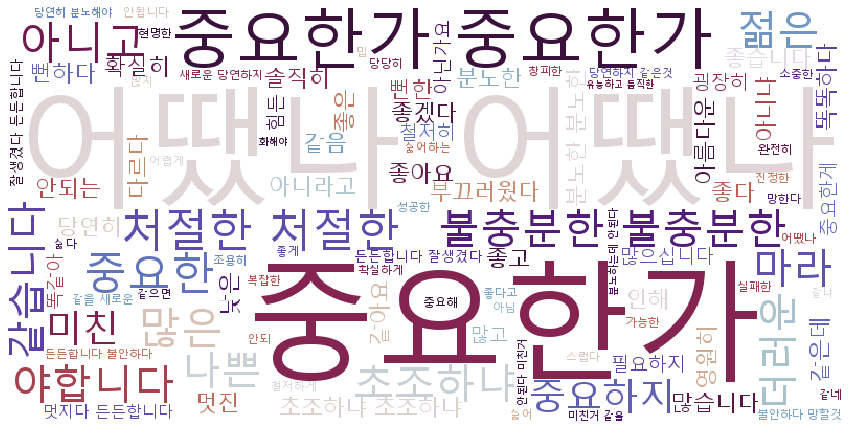

In [237]:
from wordcloud import WordCloud, STOPWORDS

wordcloud = WordCloud(font_path = font_path,
                     stopwords=stopwords,
                     colormap = 'twilight',
                     background_color='white',
                     max_words=100,
                     relative_scaling=0.1,   
                     width=800,
                     height=400
                     ).generate(' '.join(sh_adj_list))

plt.figure(figsize=(15,10))  
plt.imshow(wordcloud)       
plt.axis('off')

In [238]:
# 오세훈 후보의 긍정/부정 형용사 비율 확인

no = 0
yes = 0
for i in sh_adj_list:
    if i in np.array(positive_adj_list)[:,1]:  
        yes += 1
    elif i in np.array(negative_adj_list)[:,1]:
        no += 1
    else:
        pass
print(f'전체 형용사 텍스트에서 긍정 비율: {yes / (no+yes)}')
sh_positive_ratio = yes / (no+yes)

전체 형용사 텍스트에서 긍정 비율: 0.5444444444444444


## 3. 김영춘 후보

(-0.5, 799.5, 399.5, -0.5)

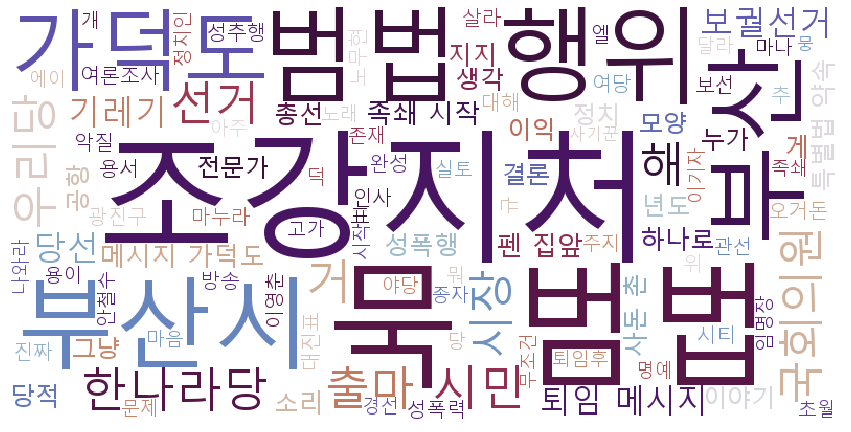

In [239]:
from wordcloud import WordCloud, STOPWORDS

wordcloud = WordCloud(font_path = font_path,
                     stopwords=stopwords,
                     colormap = 'twilight',
                     background_color='white',
                     max_words=100,
                     relative_scaling=0.1,   
                     width=800,
                     height=400
                     ).generate(' '.join(yc_noun))

plt.figure(figsize=(15,10))  
plt.imshow(wordcloud)       
plt.axis('off')

(-0.5, 799.5, 399.5, -0.5)

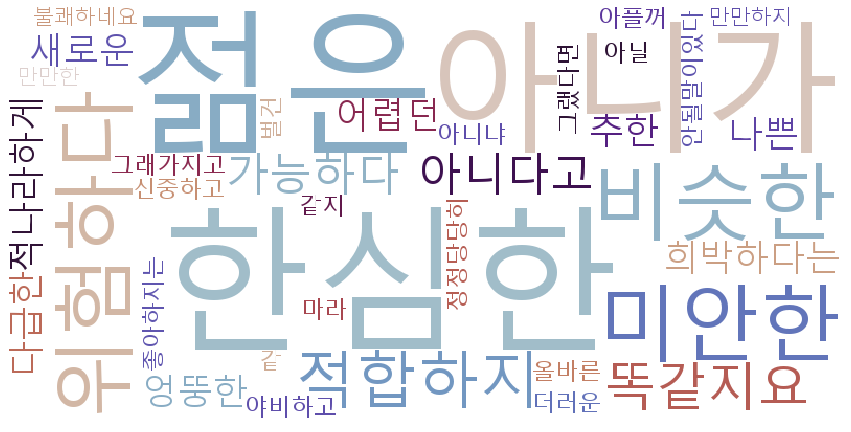

In [240]:
from wordcloud import WordCloud, STOPWORDS

wordcloud = WordCloud(font_path = font_path,
                     stopwords=stopwords,
                     colormap = 'twilight',
                     background_color='white',
                     max_words=100,
                     relative_scaling=0.1,   
                     width=800,
                     height=400
                     ).generate(' '.join(yc_adj_list))

plt.figure(figsize=(15,10))  
plt.imshow(wordcloud)       
plt.axis('off')

In [241]:
# 김영춘 후보의 긍정/부정 형용사 비율 확인

no = 0
yes = 0
for i in yc_adj_list:
    if i in np.array(positive_adj_list)[:,1]:  
        yes += 1
    elif i in np.array(negative_adj_list)[:,1]:
        no += 1
    else:
        pass
print(f'전체 형용사 텍스트에서 긍정 비율: {yes / (no+yes)}')
yc_positive_ratio = yes / (no+yes)

전체 형용사 텍스트에서 긍정 비율: 0.4


## 4. 박형준 후보

(-0.5, 799.5, 399.5, -0.5)

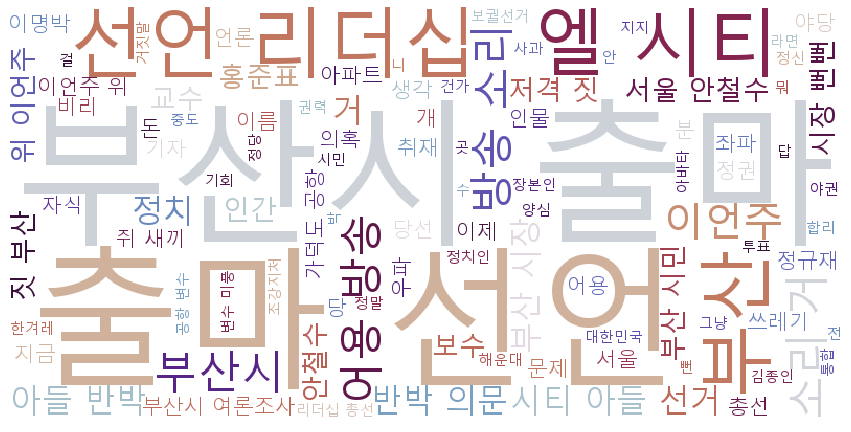

In [242]:
from wordcloud import WordCloud, STOPWORDS

wordcloud = WordCloud(font_path = font_path,
                     stopwords=stopwords,
                     colormap = 'twilight',
                     background_color='white',
                     max_words=100,
                     relative_scaling=0.1,   
                     width=800,
                     height=400
                     ).generate(' '.join(hj_noun))

plt.figure(figsize=(15,10))  
plt.imshow(wordcloud)       
plt.axis('off')

(-0.5, 799.5, 399.5, -0.5)

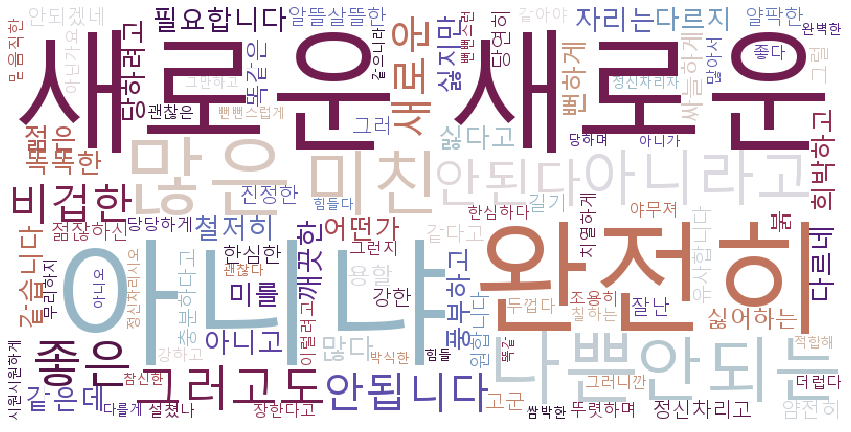

In [243]:
from wordcloud import WordCloud, STOPWORDS

wordcloud = WordCloud(font_path = font_path,
                     stopwords=stopwords,
                     colormap = 'twilight',
                     background_color='white',
                     max_words=100,
                     relative_scaling=0.1,   
                     width=800,
                     height=400
                     ).generate(' '.join(hj_adj_list))

plt.figure(figsize=(15,10))  
plt.imshow(wordcloud)       
plt.axis('off')

In [244]:
# 박형준 후보의 긍정/부정 형용사 비율 확인

no = 0
yes = 0
for i in hj_adj_list:
    if i in np.array(positive_adj_list)[:,1]:  
        yes += 1
    elif i in np.array(negative_adj_list)[:,1]:
        no += 1
    else:
        pass
print(f'전체 형용사 텍스트에서 긍정 비율: {yes / (no+yes)}')
hj_positive_ratio = yes / (no+yes)

전체 형용사 텍스트에서 긍정 비율: 0.3076923076923077


## 각 후보별 긍정 형용사 비율

- 현재까지 과정
    - 모델1에서 감성분석 진행
        - 이때 긍정/부정을 판단할 때 고려한 형태소가 무엇인지 파악했다.
        - 중요한(회귀계수가 높은) 형태소 피쳐 중 **형용사**만을 추출해 긍정/부정 형용사 단어 리스트를 저장했음

    - 모델2에서 후보자 특정 모델 생성

- 텍스트 빈도 분석
    - 모델2로 후보자를 특정한 데이터로 명사/형용사별 wordcloud형성
    - 모델1에서 저장한 **형용사 긍정/부정 단어 리스트**를 불러와 각 후보별 긍정 형용사 비율 파악


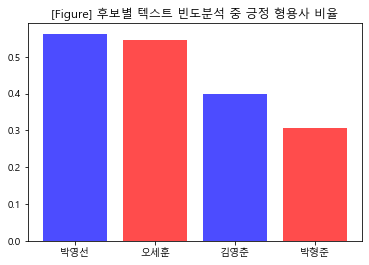

In [245]:
candidates = ['박영선','오세훈','김영춘','박형준']
plt.title('[Figure] 후보별 텍스트 빈도분석 중 긍정 형용사 비율')
plt.bar(candidates, 
        [ys_positive_ratio, sh_positive_ratio,yc_positive_ratio,hj_positive_ratio],
        color=['b','r','b','r'], alpha=0.7)
plt.show()

- 모델1(감성분석) 때 이용된 긍정/부정 형용사를 비교해본 결과, 후보별 긍정 형용사의 비율은 큰 차이가 없는 것으로 파악된다.
- 실제 모델1을 이용해 후보자별 평균 긍정률을 비교해보면, 각 지역의 2번 후보가 1번 후보들보다 높음을 알 수 있다.
- 따라서, 긍정/부정 판단에 영향을 준 형태소는 형용사 외에 명사나 용언 등 다른 형태소가 텍스트의 긍정/부정 판단에 영향을 많이 주었다고 추측해볼 수 있다.